<a href="https://colab.research.google.com/github/cu7th0n/ssq/blob/master/ssq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import xlwt
import time

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

#将数据写入Excel表格中
def write_to_excel():
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    for k in range(1,123):
        url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_%s.html' %(str(k))
        html = get_one_page(url)
        
        #写入每一期的信息
        for item in parse_one_page(html):
            sheet1.write(i+1,0,item['time'])
            sheet1.write(i+1,1,item['digit_1'])
            sheet1.write(i+1,2,item['digit_2'])
            sheet1.write(i+1,3,item['digit_3'])
            sheet1.write(i+1,4,item['digit_4'])
            sheet1.write(i+1,5,item['digit_5'])
            sheet1.write(i+1,6,item['digit_6'])
            sheet1.write(i+1,7,item['digit_7'])
            i+=1
    
    f.save('ssq.xls')
    print('%d页已保存。'%k)
    
def main():
    write_to_excel()

if __name__ == '__main__':
    main()

122页已保存。


In [2]:
import pandas as pd
data = pd.read_excel('ssq.xls')
data.head()



,date,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6,digit_7
0,2019-06-20,1,8,19,24,29,30,4
1,2019-06-18,6,15,18,19,24,32,9
2,2019-06-16,6,11,16,19,21,25,1
3,2019-06-13,3,14,20,24,26,33,10
4,2019-06-11,4,6,8,11,30,33,11


In [0]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data.reset_index(inplace=True)
del data['index']
del data['date']

In [4]:
data.head()

,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6,digit_7
0,10,11,12,13,26,28,11
1,4,9,19,20,21,26,12
2,1,7,10,23,28,32,16
3,4,6,7,10,13,25,3
4,4,6,15,17,30,31,16


In [0]:
D_1 = data['digit_1']
D_2 = data['digit_2']
D_3 = data['digit_3']
D_4 = data['digit_4']
D_5 = data['digit_5']
D_6 = data['digit_6']
D_7 = data['digit_7']

In [0]:
import numpy as np

def create_interval_dataset(dataset, look_back=7):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:i+look_back-1])
        dataY.append(dataset[i+look_back])
    return np.asarray(dataX), np.asarray(dataY)

In [0]:
def train_model(train_set,model_name, look_back = 300, data_dim = 34, batch_size = 1):
  from keras.utils import to_categorical
  from keras.models import Sequential
  from keras.layers import LSTM, Dense, Dropout
  from keras.callbacks import EarlyStopping
  import numpy as np
  import matplotlib.pyplot as plt

  timesteps = look_back-1
 
  model = Sequential()
  model.add(LSTM(data_dim, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*2, return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*8,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*4,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim*2,  return_sequences=True, stateful=True))
  model.add(Dropout(0.3))
  
  model.add(LSTM(data_dim,  stateful=True))
  model.add(Dropout(0.3))
  
  model.add(Dense(data_dim, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

  df = to_categorical(train_set,data_dim)
  
  dataX, dataY = create_interval_dataset(df, look_back)   
  
  total = len(dataX)
  split = total*8//10

  X_train = dataX[:split]
  y_train = dataY[:split]

  X_val = dataX[split+1:total-1]
  y_val = dataY[split+1:total-1]
  
  filepath='weights.best.'+  model_name[:2] + '.hdf5'
  
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15,
             verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  
  history = model.fit(X_train, y_train,batch_size=batch_size, epochs=60,
                      verbose=0, shuffle=False,
                      validation_data=(X_val, y_val),callbacks=[early_stop])
  

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model '+  model_name[:2] +  ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model '+  model_name[:2] +  ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  model.save_weights(filepath)
  model.load_weights(filepath)
  model.save(model_name)


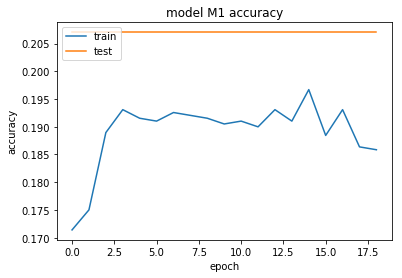

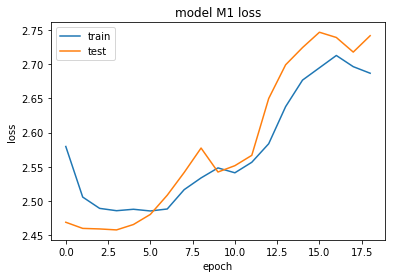

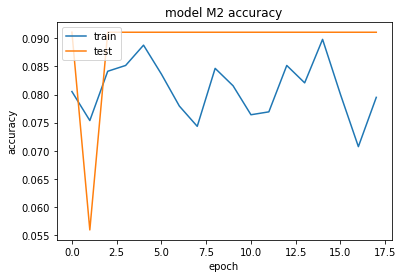

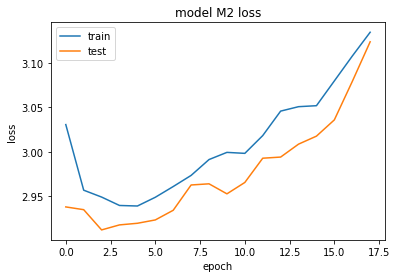

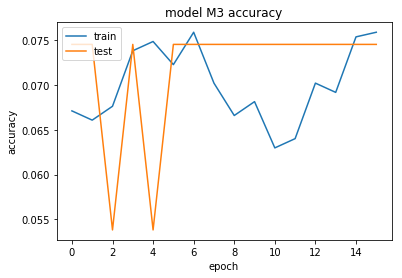

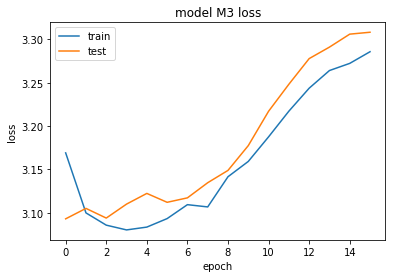

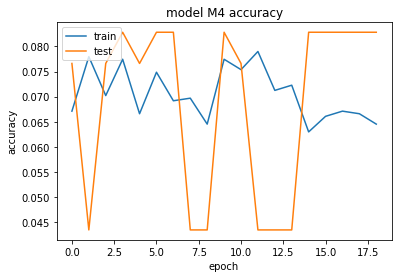

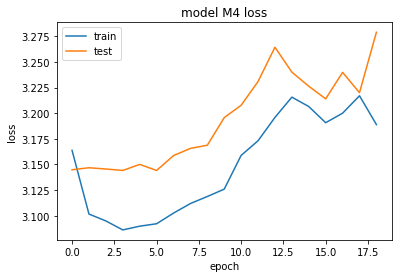

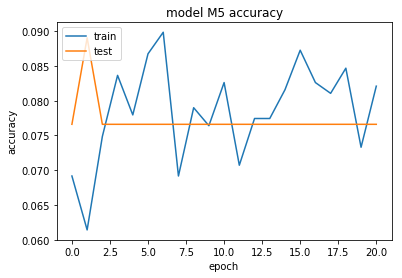

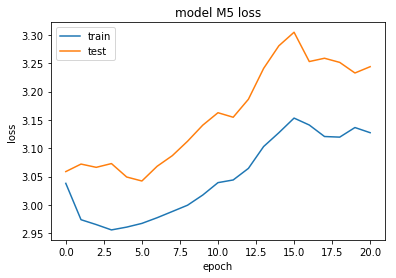

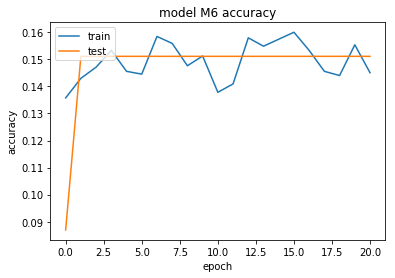

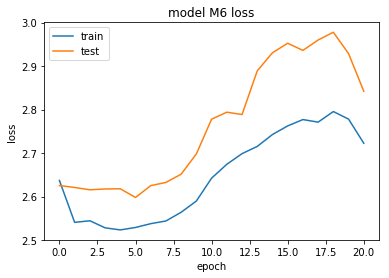

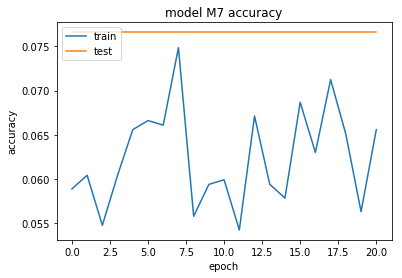

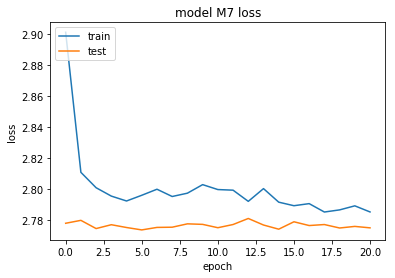

In [10]:
models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5',
          'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1, D_2, D_3, D_4, D_5, D_6, D_7]

look_back=8
for (model,tdata) in zip(models,tdatas):
  train_model(tdata,model,look_back)

M1_model.h5


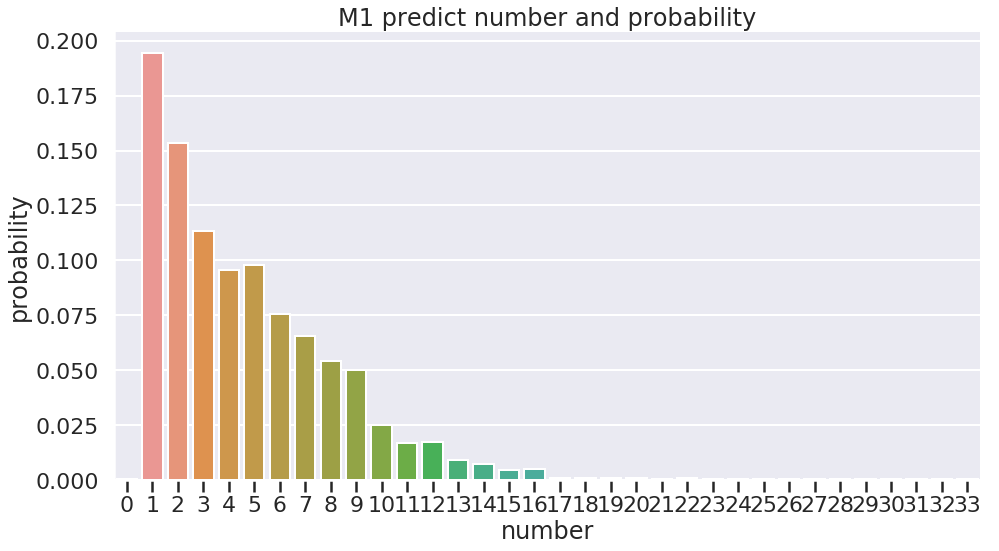

1 : 19.44%
2 : 15.33%
3 : 11.33%
5 : 9.79%
4 : 9.57%
6 : 7.56%
7 : 6.58%
8 : 5.43%
9 : 5.03%
10 : 2.53%
12 : 1.74%
11 : 1.69%
13 : 0.91%
14 : 0.76%
16 : 0.53%
15 : 0.45%
17 : 0.12%
20 : 0.10%
18 : 0.10%
22 : 0.09%
19 : 0.09%
30 : 0.07%
32 : 0.07%
28 : 0.07%
26 : 0.07%
24 : 0.07%
27 : 0.06%
31 : 0.06%
21 : 0.06%
0 : 0.06%
29 : 0.06%
23 : 0.06%
33 : 0.06%


M2_model.h5


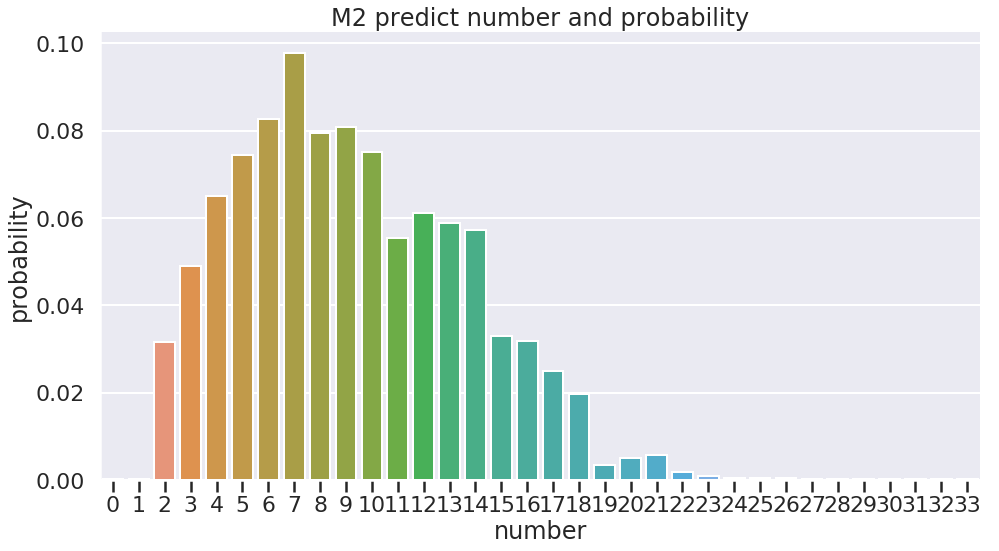

7 : 9.77%
6 : 8.27%
9 : 8.07%
8 : 7.94%
10 : 7.51%
5 : 7.43%
4 : 6.51%
12 : 6.12%
13 : 5.89%
14 : 5.74%
11 : 5.53%
3 : 4.91%
15 : 3.29%
16 : 3.18%
2 : 3.16%
17 : 2.50%
18 : 1.97%
21 : 0.59%
20 : 0.51%
19 : 0.34%
22 : 0.20%
23 : 0.10%
24 : 0.05%
25 : 0.05%
26 : 0.05%
0 : 0.04%
1 : 0.04%
28 : 0.03%
32 : 0.03%
31 : 0.03%
29 : 0.03%
30 : 0.03%
33 : 0.03%


M3_model.h5


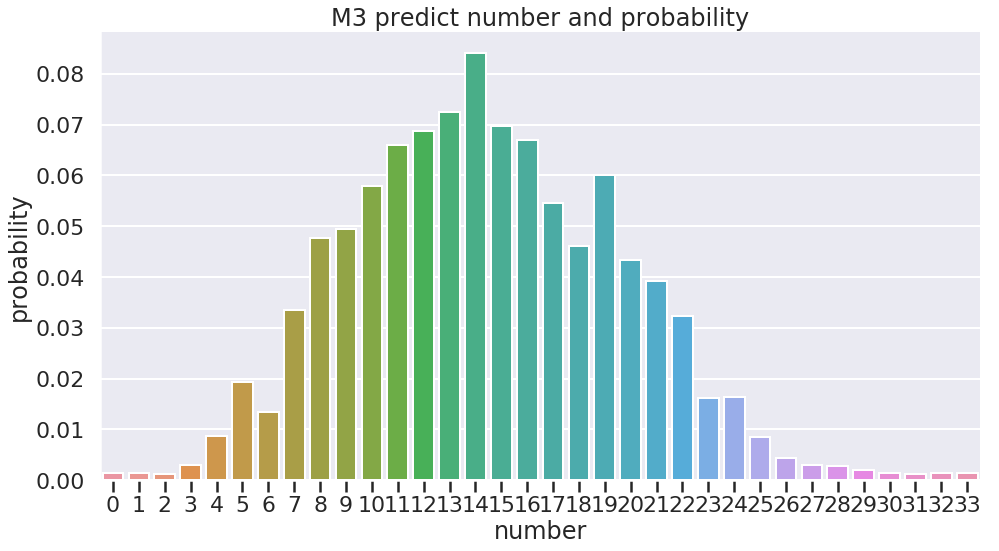

14 : 8.41%
13 : 7.25%
15 : 6.98%
12 : 6.87%
16 : 6.70%
11 : 6.59%
19 : 6.01%
10 : 5.79%
17 : 5.45%
9 : 4.95%
8 : 4.76%
18 : 4.61%
20 : 4.33%
21 : 3.93%
7 : 3.36%
22 : 3.24%
5 : 1.94%
24 : 1.64%
23 : 1.63%
6 : 1.35%
4 : 0.87%
25 : 0.86%
26 : 0.44%
3 : 0.31%
27 : 0.30%
28 : 0.29%
29 : 0.20%
33 : 0.15%
32 : 0.14%
30 : 0.14%
1 : 0.14%
0 : 0.14%
31 : 0.13%


M4_model.h5


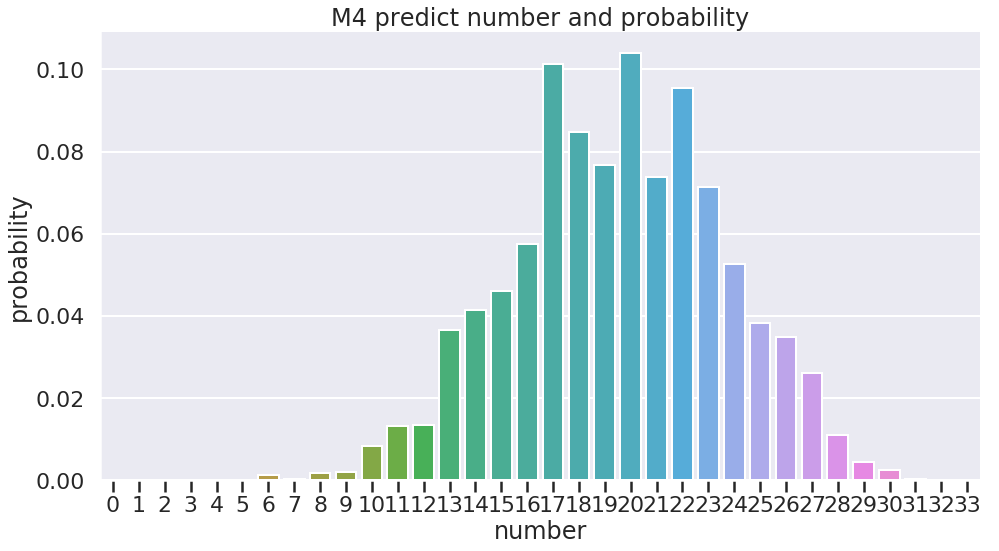

20 : 10.40%
17 : 10.14%
22 : 9.55%
18 : 8.47%
19 : 7.67%
21 : 7.38%
23 : 7.14%
16 : 5.76%
24 : 5.26%
15 : 4.61%
14 : 4.15%
25 : 3.82%
13 : 3.66%
26 : 3.48%
27 : 2.62%
12 : 1.36%
11 : 1.32%
28 : 1.11%
10 : 0.84%
29 : 0.46%
30 : 0.24%
9 : 0.19%
8 : 0.17%
6 : 0.12%
31 : 0.03%
7 : 0.02%
5 : 0.01%
1 : 0.00%
0 : 0.00%
4 : 0.00%
32 : 0.00%
2 : 0.00%
3 : 0.00%


M5_model.h5


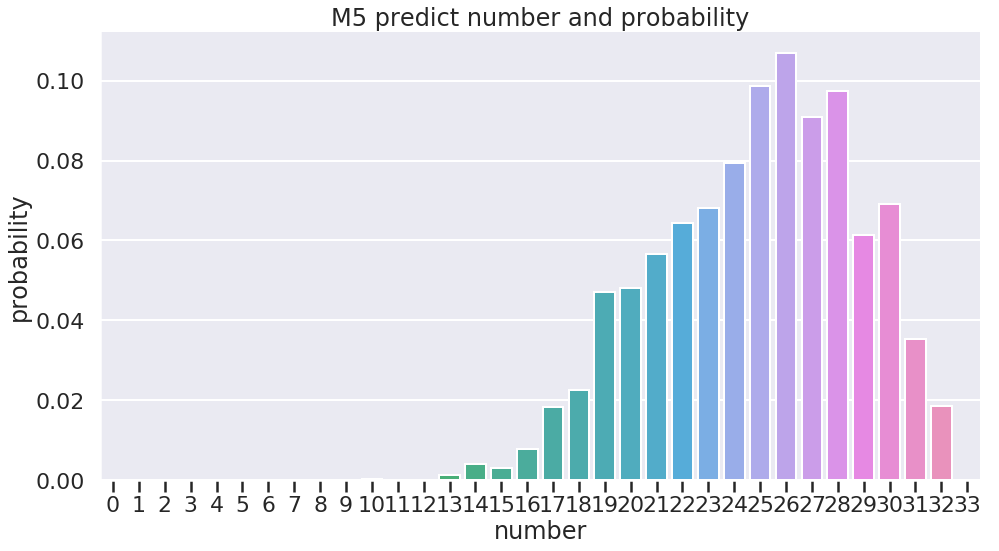

26 : 10.69%
25 : 9.87%
28 : 9.74%
27 : 9.08%
24 : 7.93%
30 : 6.91%
23 : 6.82%
22 : 6.43%
29 : 6.15%
21 : 5.65%
20 : 4.81%
19 : 4.72%
31 : 3.54%
18 : 2.27%
32 : 1.85%
17 : 1.84%
16 : 0.79%
14 : 0.42%
15 : 0.32%
13 : 0.12%
10 : 0.02%
12 : 0.02%
11 : 0.01%
8 : 0.01%
9 : 0.00%
7 : 0.00%
4 : 0.00%
3 : 0.00%
0 : 0.00%
2 : 0.00%
5 : 0.00%
33 : 0.00%
6 : 0.00%


M6_model.h5


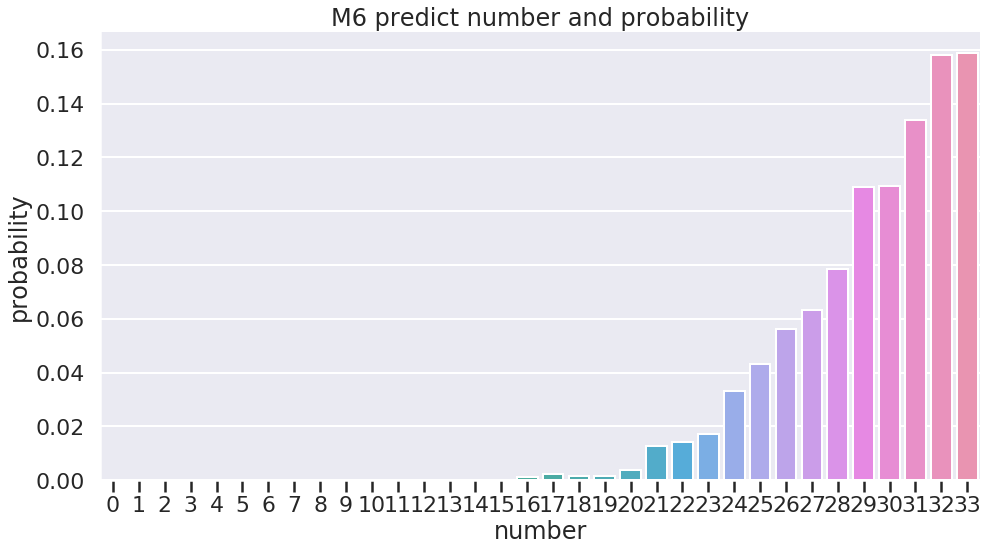

33 : 15.88%
32 : 15.80%
31 : 13.40%
30 : 10.92%
29 : 10.91%
28 : 7.84%
27 : 6.33%
26 : 5.62%
25 : 4.33%
24 : 3.33%
23 : 1.71%
22 : 1.41%
21 : 1.26%
20 : 0.38%
17 : 0.24%
19 : 0.16%
18 : 0.16%
16 : 0.11%
15 : 0.03%
14 : 0.02%
11 : 0.01%
6 : 0.01%
8 : 0.01%
1 : 0.01%
0 : 0.01%
12 : 0.01%
2 : 0.01%
3 : 0.01%
7 : 0.01%
9 : 0.01%
5 : 0.01%
4 : 0.01%
13 : 0.01%


M7_model.h5


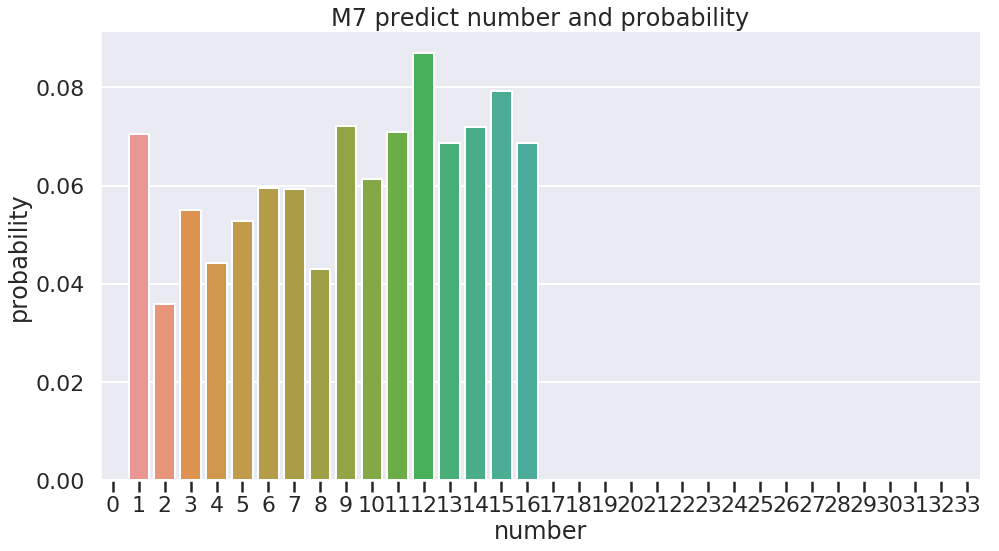

12 : 8.70%
15 : 7.92%
9 : 7.21%
14 : 7.19%
11 : 7.08%
1 : 7.06%
16 : 6.88%
13 : 6.86%
10 : 6.13%
6 : 5.94%
7 : 5.93%
3 : 5.50%
5 : 5.28%
4 : 4.42%
8 : 4.30%
2 : 3.58%
32 : 0.00%
26 : 0.00%
20 : 0.00%
33 : 0.00%
29 : 0.00%
25 : 0.00%
23 : 0.00%
19 : 0.00%
0 : 0.00%
28 : 0.00%
30 : 0.00%
31 : 0.00%
27 : 0.00%
17 : 0.00%
18 : 0.00%
21 : 0.00%
22 : 0.00%


Predicted numbers : 
[1, 7, 14, 20, 26, 33, 12]
Total probability : 0.0000245138%


In [11]:
from keras.models import load_model
from keras.utils import to_categorical
import seaborn as sns
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import xlwt
import time
import matplotlib.pyplot as plt

look_back=8-1

#获取第一页的内容
def get_one_page(url):
    headers = {
        'User-Agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36'
    }
    response = requests.get(url,headers=headers)
    if response.status_code == 200:
        return response.text
    return 

#解析第一页内容，数据结构化
def parse_one_page(html):

    soup = BeautifulSoup(html,'lxml')
    i = 0
    for item in soup.select('tr')[2:-1]:

        yield{
            'time':item.select('td')[i].text,
            'digit_1':item.select('td em')[0].text,
            'digit_2':item.select('td em')[1].text,
            'digit_3':item.select('td em')[2].text,
            'digit_4':item.select('td em')[3].text,
            'digit_5':item.select('td em')[4].text,
            'digit_6':item.select('td em')[5].text,
            'digit_7':item.select('td em')[6].text,
        }

def create_test_excel(look_back):
    f = xlwt.Workbook()                             
    sheet1 = f.add_sheet('ssq',cell_overwrite_ok=True)
    row0 = ["date","digit_1","digit_2","digit_3","digit_4","digit_5","digit_6","digit_7"]
    #写入第一行
    for j in range(0,len(row0)):
        sheet1.write(0,j,row0[j])

    #依次爬取每一页内容的每一期信息，并将其依次写入Excel
    i=0
    url = 'http://kaijiang.zhcw.com/zhcw/html/ssq/list_1.html' 
    html = get_one_page(url)
        
        #写入每一期的信息
    for item in parse_one_page(html):
      
      sheet1.write(i+1,0,item['time'])
      sheet1.write(i+1,1,item['digit_1'])
      sheet1.write(i+1,2,item['digit_2'])
      sheet1.write(i+1,3,item['digit_3'])
      sheet1.write(i+1,4,item['digit_4'])
      sheet1.write(i+1,5,item['digit_5'])
      sheet1.write(i+1,6,item['digit_6'])
      sheet1.write(i+1,7,item['digit_7'])
      i+=1
            
      if i == look_back + 1:
        break
    
    f.save('ssq_test.xls')

create_test_excel(look_back)
data = pd.read_excel('ssq_test.xls')
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by = 'date')
data.reset_index(inplace=True)
del data['index']
del data['date']

D_1 = data['digit_1']
D_2 = data['digit_2']
D_3 = data['digit_3']
D_4 = data['digit_4']
D_5 = data['digit_5']
D_6 = data['digit_6']
D_7 = data['digit_7']

models = ['M1_model.h5', 'M2_model.h5', 'M3_model.h5', 'M4_model.h5', 'M5_model.h5','M6_model.h5','M7_model.h5']
tdatas = [D_1,D_2,D_3,D_4,D_5,D_6,D_7]

total_prob = 1

pred_num = []

for (model,tdata) in zip(models,tdatas):
    
    print(model)
    M_ssq = load_model(model)

    test_X = to_categorical(np.asarray([tdata[-look_back:]]),num_classes=34)

    pred = M_ssq.predict(test_X)
    ranks = np.argsort(pred[0])
    
    
    dfp = pd.DataFrame(pred)
    dfplot = pd.DataFrame()
    dfplot['probability'] = dfp.T[0]
    dfplot['number'] = dfplot.index
    
    sns.set_context("poster")
    sns.set_style("darkgrid",{'xtick.bottom': True})
    sns.catplot(x='number',y='probability', kind="bar", height=8, aspect=1.8, data=dfplot)
    plt.title(model[:2] + ' predict number and probability')
    plt.ylabel('probability')
    plt.xlabel('number')
    plt.show()
    
    for i in range(1,34):
        print(str(ranks[-i]) + ' : %.2f%%' %(pred[0][ranks[-i]]*100))
    print('\n')
    
    max_prob = pred[0][ranks[-1]]
    
    pred_num.append(ranks[-1])
    
    total_prob = total_prob * max_prob
    
print('Predicted numbers : ')
print(pred_num)
print('Total probability : %.10f%%' %(total_prob*100))

In [0]:
0.00000564299％